# **Importações**

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import os
import statsmodels.api as sm
import glob
import datetime

from fuzzywuzzy import fuzz
from typing import List
from datetime import timedelta
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import preprocessing as pp
from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

warnings.filterwarnings('ignore')

# **Funções auxiliares**

In [3]:
def jupyter_settings():
    # Usar matplotlib inline
    %matplotlib inline
    
    # Configurar estilo do plot
    plt.style.use("bmh")
    plt.rcParams["figure.figsize"] = (25, 12)
    plt.rcParams["font.size"] = 24

    # Ajustar visualização do dataframe
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option("display.expand_frame_repr", False)

    # Configurar seaborn
    sns.set_theme()


def ml_error(model_name, y, yhat):
    """
    Calcula e retorna métricas de erro para um modelo.

    Argumentos:
        model_name (str): Nome do modelo.
        y (array): Valores reais.
        yhat (array): Valores previstos.

    Retorna:
        DataFrame com as métricas de erro.
    """

    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))

    return pd.DataFrame(
        {
            "Modelo": model_name,
            "MAE": mae,
            "MAPE": mape,
            "RMSE": rmse,
        },
        index=[0],
    )

layout = go.Layout(
    autosize=False,
    width=800,
    height=250,
    margin=dict(l=10, r=10, b=10, t=10, pad=6),
)

jupyter_settings()

# **Agrupamendo de dados**
* Coleta de dados da unisa fotovoltaico.
* Pré-processar os dados para limpar, normalizar e transformar os dados brutos.

## *Processamento de dados*

In [56]:
# # Lista de pastas
# lista_pasta = ["41", "42", "44"]

# for lp in lista_pasta:
#     folder = os.path.join("datasets", "campinas", lp)
#     out_folder = os.path.join("datasets", "campinas", lp + ".1")
#     for count, filename in enumerate(os.listdir(folder), start=1):
#         read_file = pd.read_excel(os.path.join(folder, filename))
#         out_file = "054B7020C0200{}_{}.csv".format(lp, count)
#         read_file.to_csv(os.path.join(out_folder, out_file), index=None, header=True)


In [10]:
def processa_arquivos(path):
  # Cria a lista all_files dentro da função
  all_files = glob.glob(path + "/*.csv")
  # Obtém uma lista de todos os arquivos CSV
  all_files: List[str] = glob.glob(path + "/*.csv")

  # Cria uma lista para armazenar os DataFrames
  df_list: List[pd.DataFrame] = []
  
  # Lê cada arquivo CSV, processa e adiciona à lista df_list
  for filename in all_files:
    df = pd.read_csv(filename, skiprows=7)
    df['Time'] = pd.to_datetime(df['Time'].str.split("(", n=1, expand=True)[0].str.strip(), format='%d/%m/%Y %H:%M:%S')

    # Filtragem por data (mesmo código original)
    data_min = datetime.datetime(2022, 12, 21)
    data_max = datetime.datetime(2023, 12, 21)
    df = df.loc[df['Time'] >= data_min]
    df = df.loc[df['Time'] <= data_max]

    # Limpa o DataFrame
    df = clean_data(df)

    # Atribui o valor do inversor
    df['Inverter'] = '054B7020C020041'  # Insira o valor correto para o arquivo atual

    df['Count'] = np.arange(len(df))  # Adiciona coluna de contagem

    df_list.append(df)

  # Concatena todos os DataFrames processados
  df_raw = pd.concat(df_list, axis=0, ignore_index=True)
  
  # Remove linhas duplicadas (mesmo código original)
  df_raw = df_raw.drop_duplicates(subset='Time', keep='first')

  # Ordena por Time (mesmo código original)
  df_raw.sort_values('Time', inplace=True)

  # Converte Time para datetime (mesmo código original)
  df_raw['Time'] = pd.to_datetime(df_raw['Time'])
  
  return df_raw


def clean_data(df):
  # Remove a coluna 'Number'
  df.drop('Number', axis=1, inplace=True)

  # Seleciona colunas de interesse
  cols = ['Time', 'DC Power PvPV1(W)', 'DC Power PvPV2(W)', 'DC Power PvPV3(W)', 'DC Power PvPV4(W)', 'Total Inverter Power(W)', 'Today Yield(kWh)', 'Total Yield(kWh)', 'IGBT Temperature(℃)']
  df = df[cols]

  # Cálculo da potência total DC
  df['DC Total Power'] = df['DC Power PvPV1(W)'] + df['DC Power PvPV2(W)'] + df['DC Power PvPV3(W)']

  # Remove colunas redundantes
  df.drop(['DC Power PvPV1(W)', 'DC Power PvPV2(W)', 'DC Power PvPV3(W)', 'DC Power PvPV4(W)'], axis=1, inplace=True)

  # Limpa a coluna Time
  df['Time'] = df['Time'].str.replace(' (UTC-4:00)', '')
  df['Time'] = pd.to_datetime(df['Time'], dayfirst=True)

  # Cria a coluna Date
  df['Date'] = df['Time'].dt.date

  return df

# Dicionário mapeando nome do arquivo para valor do inversor
inversores = {
  '41.csv': '054B7020C020041',
  '42.csv': '054B7020C020042',
  '44.csv': '054B7020C020044',
}

# Processa cada arquivo
df_list = []
for filename in all_files:
  if filename.endswith('.csv'):
    df = pd.read_csv(filename, skiprows=7)
  elif filename.endswith('.xlsx'):
    df = pd.read_excel(filename)
  else:
    continue

  df = clean_data(df)
  df['Inverter'] = inversores[filename]
  df_list.append(df)

# Concatena DataFrames
dfPower = pd.concat(df_list, ignore_index=True)

# Ordena por Time e redefine o índice
dfPower = dfPower.sort_values(by=['Time'])
dfPower.reset_index(inplace=True)
dfPower.drop(columns=['index'], inplace=True, axis=1)

KeyError: "['Number'] not found in axis"

In [6]:
# Define o identificador do inversor
inversores = {
    "42.1": "054B7020C020042",
    "41.1": "054B7020C020041",
    "44.1": "054B7020C020044",
}

# Define o caminho base para o diretório
path_inversor = "datasets/campinas"

# Processa os arquivos
lista_dataframes = []  # Lista para armazenar os DataFrames processados
for sub_diretorio in ["42.1", "41.1", "44.1"]:
    caminho_completo = os.path.join(path_inversor, sub_diretorio)

    # Valida se o identificador do inversor existe
    if sub_diretorio not in inversores:
        raise ValueError(f"Identificador do inversor para '{sub_diretorio}' não encontrado.")

    try:
        df_processado = ler_e_processar_arquivo(caminho_completo, inversores[sub_diretorio])
    except ValueError as e:
        print(f"Erro processando arquivo no diretório {caminho_completo}: {e}")
    else:
        if df_processado is not None:
            lista_dataframes.append(df_processado)

# Verifica se há DataFrames processados
if not lista_dataframes:
    print("Nenhum arquivo processado com sucesso.")
    exit()

# Concatena os DataFrames processados
dfPower = pd.concat(lista_dataframes, ignore_index=True)

# Ordena por data e hora
dfPower["Time"] = pd.to_datetime(dfPower["Time"])

# Cria coluna "Date" a partir de "Time"
dfPower["Date"] = dfPower["Time"].dt.date

# Redefine o índice para valores inteiros consecutivos
dfPower.reset_index(inplace=True)
dfPower.drop(columns=["index"], inplace=True)

# Agora `dfPower` contém os dados processados e limpos dos três inversores

# Mostra as primeiras linhas do DataFrame
dfPower.head()


Erro processando arquivo no diretório datasets/campinas/42.1: Arquivo 'dados_inversor.csv' não encontrado no diretório datasets/campinas/42.1.
Erro processando arquivo no diretório datasets/campinas/41.1: Arquivo 'dados_inversor.csv' não encontrado no diretório datasets/campinas/41.1.
Erro processando arquivo no diretório datasets/campinas/44.1: Arquivo 'dados_inversor.csv' não encontrado no diretório datasets/campinas/44.1.
Nenhum arquivo processado com sucesso.


ValueError: No objects to concatenate

: 

In [7]:
# Antes de salvar os novos arquivos, verifique se há arquivos antigos e exclua-os
for df, path in [(df_42, 'datasets/campinas/42.1'), (df_41, 'datasets/campinas/41.1'), (df_44, 'datasets/campinas/44.1')]:
    if os.path.exists(path + '.csv'):
        os.remove(path + '.csv')
    df.to_csv(path + '.csv', index=False)


In [8]:
# Salva os DataFrames em arquivos CSV
df_42.to_csv('datasets/campinas/42.1_processed.csv', index=False)
df_41.to_csv('datasets/campinas/41.1_processed.csv', index=False)
df_44.to_csv('datasets/campinas/44.1_processed.csv', index=False)


In [9]:
df_41.head()

,Number,Time,Working State,Alarm Code,DC Voltage PvPV1(V),DC Current PvPV1(A),DC Power PvPV1(W),DC Voltage PvPV2(V),DC Current PvPV2(A),DC Power PvPV2(W),DC Voltage PvPV3(V),DC Current PvPV3(A),DC Power PvPV3(W),DC Voltage PvPV4(V),DC Current PvPV4(A),DC Power PvPV4(W),AC Voltage U(V),AC Voltage V(V),AC Voltage W(V),AC Current U(A),AC Current V(A),AC Current W(A),Total Inverter Power(W),AC Frequency(Hz),Today Yield(kWh),Month Yield(kWh),Annual Yield(kWh),Total Yield(kWh),IGBT Temperature(℃),Inverter Ambient Temperature(℃),Dispersion Rate,Initialize the grounding voltage(V),DC bus voltage(V),Dc bus half voltage(V),Insulation Resistance Realtime Value,Count
0,1,2022-12-21 04:16:34,Normal,,103.0,0.1,10,104.3,0.1,10,101.0,0.1,10,1.4,0.1,0,222.6,NaN,NaN,0.2,NaN,NaN,20.0,60.01,0.0,834.0,13132.0,17510.0,25.6,,0.0,0.0,0.0,0.0,,0
1,2,2022-12-21 04:21:34,Normal,,292.0,0.1,29,263.6,0.1,26,264.2,0.1,26,17.0,0.1,0,223.0,NaN,NaN,2.5,NaN,NaN,20.0,59.99,0.0,834.0,13132.0,17510.0,26.1,,0.0,0.0,0.0,0.0,,1
2,3,2022-12-21 04:26:34,Normal,,294.0,0.1,29,264.9,0.1,26,265.5,0.1,27,17.3,0.1,0,223.2,NaN,NaN,2.6,NaN,NaN,20.0,59.98,0.0,834.0,13132.0,17510.0,26.6,,0.0,0.0,0.0,0.0,,2
3,4,2022-12-21 04:31:36,Normal,,304.2,0.1,30,264.9,0.1,26,275.1,0.1,28,13.4,0.1,0,223.5,NaN,NaN,2.6,NaN,NaN,20.0,60.02,0.0,834.0,13132.0,17510.0,27.2,,0.0,0.0,0.0,0.0,,3
4,5,2022-12-21 04:36:40,Normal,,308.4,0.1,31,265.0,0.1,27,279.3,0.1,28,13.0,0.1,0,223.4,NaN,NaN,2.6,NaN,NaN,40.0,60.01,0.0,834.0,13132.0,17510.0,27.7,,0.0,0.0,0.0,0.0,,4


In [10]:
def verificar_colunas(df, columns):
  """
  Verifica se todas as colunas em "columns" estão presentes em "df".

  Args:
    df: DataFrame a ser verificado.
    columns: Lista de colunas a serem verificadas.

  Returns:
    missing_columns: Lista de colunas ausentes em "df".
    extra_columns: Lista de colunas em "df" que não estão em "columns".
  """
  missing_columns = [item for item in columns if item not in df.columns]
  extra_columns = [item for item in df.columns if item not in columns]
  return missing_columns, extra_columns

# colunas a serem atualizadas
columns = ['Count','Time', 'Total Inverter Power(W)', 'AC Voltage U(V)', 'AC Current U(A)', 'Today Yield(kWh)', 'Total Yield(kWh)', 'IGBT  Temperature(℃)']

# Verifica colunas no df_41
missing_columns_41, extra_columns_41 = verificar_colunas(df_41, columns)

# Verifica colunas no df_42
missing_columns_42, extra_columns_42 = verificar_colunas(df_42, columns)

# Verifica colunas no df_44
missing_columns_44, extra_columns_44 = verificar_colunas(df_44, columns)

# Imprime mensagens de acordo com os resultados

if not missing_columns_41 and not extra_columns_41:
  print("Tudo certo nas colunas do df_41.")
elif missing_columns_41:
  print("Verificar planilha df_41. Coluna(s) ausente(s):", missing_columns_41)
if extra_columns_41:
  print("Estas colunas não estão presentes na atividade de atualização do df_41:", extra_columns_41)

# Imprime mensagens de acordo com os resultados

if not missing_columns_42 and not extra_columns_42:
  print("Tudo certo nas colunas do df_42.")
elif missing_columns_42:
  print("Verificar planilha df_42. Coluna(s) ausente(s):", missing_columns_42)
if extra_columns_42:
  print("Estas colunas não estão presentes na atividade de atualização do df_42:", extra_columns_42)
  
# Imprime mensagens de acordo com os resultados

if not missing_columns_44 and not extra_columns_44:
  print("Tudo certo nas colunas do df_44.")
elif missing_columns_44:
  print("Verificar planilha df_44. Coluna(s) ausente(s):", missing_columns_44)
if extra_columns_44:
  print("Estas colunas não estão presentes na atividade de atualização do df_44:", extra_columns_44)

print(f"df_41: {df_41.shape[0]} linhas, {df_41.shape[1]} colunas", df_41.dtypes, df_41.isna().sum())
print(f"df_42: {df_42.shape[0]} linhas, {df_42.shape[1]} colunas", df_42.dtypes, df_42.isna().sum())
print(f"df_44: {df_44.shape[0]} linhas, {df_44.shape[1]} colunas", df_44.dtypes, df_44.isna().sum())


Estas colunas não estão presentes na atividade de atualização do df_41: ['Number', 'Working State', 'Alarm Code', 'DC Voltage PvPV1(V)', 'DC Current PvPV1(A)', 'DC Power PvPV1(W)', 'DC Voltage PvPV2(V)', 'DC Current PvPV2(A)', 'DC Power PvPV2(W)', 'DC Voltage PvPV3(V)', 'DC Current PvPV3(A)', 'DC Power PvPV3(W)', 'DC Voltage PvPV4(V)', 'DC Current PvPV4(A)', 'DC Power PvPV4(W)', 'AC Voltage V(V)', 'AC Voltage W(V)', 'AC Current V(A)', 'AC Current W(A)', 'AC Frequency(Hz)', 'Month Yield(kWh)', 'Annual Yield(kWh)', 'Inverter Ambient Temperature(℃)', 'Dispersion Rate', 'Initialize the grounding voltage(V)', 'DC bus voltage(V)', 'Dc bus half voltage(V)', 'Insulation Resistance Realtime Value']
Estas colunas não estão presentes na atividade de atualização do df_42: ['Number', 'Working State', 'Alarm Code', 'DC Voltage PvPV1(V)', 'DC Current PvPV1(A)', 'DC Power PvPV1(W)', 'DC Voltage PvPV2(V)', 'DC Current PvPV2(A)', 'DC Power PvPV2(W)', 'DC Voltage PvPV3(V)', 'DC Current PvPV3(A)', 'DC Pow

In [11]:
def calcular_estatisticas(df):
    # Calcula estatísticas descritivas
    num_attributes = df.select_dtypes(include=["int64", "float64"])

    # Central Tendency - média, mediana
    central_tendency = pd.DataFrame(
        {
            "mean": num_attributes.mean(axis=0),
            "median": num_attributes.median(axis=0),
        }
    ).T

    # Dispersion - std, min, max, range, skew, kurtosis
    dispersion = pd.DataFrame(
        {
            "std": num_attributes.std(axis=0),
            "min": num_attributes.min(axis=0),
            "max": num_attributes.max(axis=0),
            "range": num_attributes.max(axis=0) - num_attributes.min(axis=0),
            "skew": num_attributes.skew(axis=0),
            "kurtosis": num_attributes.kurtosis(axis=0),
        }
    ).T
    
    # Concatenação
    stats = pd.concat([dispersion, central_tendency], axis=1)
    stats.index.name = "attributes"
    return stats.reset_index()


In [12]:
# Cálculo das estatísticas para cada DataFrame
df_41_stats = calcular_estatisticas(df_41)
df_42_stats = calcular_estatisticas(df_42)
df_44_stats = calcular_estatisticas(df_44)

# Imprime as estatísticas de cada DataFrame usando um f-string e formatação de tabela
print("Estatísticas dos DataFrames:")
print(f"\nInversor 41:\n{df_41_stats.to_string()}")
print(f"\nInversor 42:\n{df_42_stats.to_string()}")
print(f"\nInversor 44:\n{df_44_stats.to_string()}")

Estatísticas dos DataFrames:

Inversor 41:
  attributes       Number  DC Voltage PvPV1(V)  DC Current PvPV1(A)  DC Power PvPV1(W)  DC Voltage PvPV2(V)  DC Current PvPV2(A)  DC Power PvPV2(W)  DC Voltage PvPV3(V)  DC Current PvPV3(A)  DC Power PvPV3(W)  DC Voltage PvPV4(V)  DC Current PvPV4(A)  DC Power PvPV4(W)  AC Voltage U(V)  AC Voltage V(V)  AC Voltage W(V)  AC Current U(A)  AC Current V(A)  AC Current W(A)  Total Inverter Power(W)  AC Frequency(Hz)  Today Yield(kWh)  Month Yield(kWh)  Annual Yield(kWh)  Total Yield(kWh)  IGBT  Temperature(℃)  Dispersion Rate  Initialize the grounding voltage(V)  DC bus voltage(V)  Dc bus half voltage(V)         Count      Number  DC Voltage PvPV1(V)  DC Current PvPV1(A)  DC Power PvPV1(W)  DC Voltage PvPV2(V)  DC Current PvPV2(A)  DC Power PvPV2(W)  DC Voltage PvPV3(V)  DC Current PvPV3(A)  DC Power PvPV3(W)  DC Voltage PvPV4(V)  DC Current PvPV4(A)  DC Power PvPV4(W)  AC Voltage U(V)  AC Voltage V(V)  AC Voltage W(V)  AC Current U(A)  AC Current 

In [13]:
# Seleciona e exibe atributos categóricos para cada DataFrame
for df_name, df in [("df_41", df_41), ("df_42", df_42), ("df_44", df_44)]:
    cat_attributes = df.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])
    print(f"\nAtributos categóricos de {df_name}:\n{cat_attributes.head(10)}")



Atributos categóricos de df_41:
                  Time Working State Alarm Code Inverter Ambient Temperature(℃) Insulation Resistance Realtime Value
0  2022-12-21 04:16:34        Normal                                                                                
1  2022-12-21 04:21:34        Normal                                                                                
2  2022-12-21 04:26:34        Normal                                                                                
3  2022-12-21 04:31:36        Normal                                                                                
4  2022-12-21 04:36:40        Normal                                                                                
5  2022-12-21 04:41:40        Normal                                                                                
6  2022-12-21 04:46:39        Normal                                                                                
7  2022-12-21 04:51:39        N

In [14]:
# Verifica o tipo da coluna 'Time' em cada DataFrame
print(f"\nTipo da coluna 'Time' no df_41: {df_41['Time'].dtype}")
print(f"\nTipo da coluna 'Time' no df_42: {df_42['Time'].dtype}")
print(f"\nTipo da coluna 'Time' no df_44: {df_44['Time'].dtype}")

# Converte a coluna 'Time' em dateTime se necessário
def extrai_informacoes_data(df):

    """
    Extrai informações da coluna 'Time' e adiciona novas colunas ao DataFrame.

    Parâmetros:
        df (pd.DataFrame): DataFrame com a coluna 'Time'.

    Retorna:
        pd.DataFrame: DataFrame com as novas colunas adicionadas.
    """

    try:
        df['Time'] = pd.to_datetime(df['Time'], format='%Y-%m-%d %H:%M:%S')
    except ValueError:
        print("Erro ao converter a coluna 'Time' no DataFrame df_41")

    # Extrai o ano
    df['ano'] = df['Time'].dt.year

    # Extrai o mês
    df['mês'] = df['Time'].dt.month

    # Extrai a semana do ano
    df['semana_do_ano'] = df['Time'].dt.isocalendar().week

    # Extrai o dia da semana (ajustando o índice para 1-7)
    df['dia_da_semana'] = df['Time'].dt.dayofweek.apply(lambda x: x + 1) + 1

    # Extrai o dia do mês
    df['dia'] = df['Time'].dt.day

    # Extrai a hora
    df['hora'] = df['Time'].dt.hour

    # Extrai o minuto
    df['minuto'] = df['Time'].dt.minute

    return df

# Seleciona uma pequena parte do DataFrame
df_41_teste = df_41.head(175)

# Extrai informações de cada DataFrame
df_41 = extrai_informacoes_data(df_41.copy())
df_42 = extrai_informacoes_data(df_42.copy())
df_44 = extrai_informacoes_data(df_44.copy())

# Verifica os resultados
print(f"\n{df_41_teste}")



Tipo da coluna 'Time' no df_41: object

Tipo da coluna 'Time' no df_42: object

Tipo da coluna 'Time' no df_44: object



     Number                 Time Working State Alarm Code  DC Voltage PvPV1(V)  DC Current PvPV1(A)  DC Power PvPV1(W)  DC Voltage PvPV2(V)  DC Current PvPV2(A)  DC Power PvPV2(W)  DC Voltage PvPV3(V)  DC Current PvPV3(A)  DC Power PvPV3(W)  DC Voltage PvPV4(V)  DC Current PvPV4(A)  DC Power PvPV4(W)  AC Voltage U(V)  AC Voltage V(V)  AC Voltage W(V)  AC Current U(A)  AC Current V(A)  AC Current W(A)  Total Inverter Power(W)  AC Frequency(Hz)  Today Yield(kWh)  Month Yield(kWh)  Annual Yield(kWh)  Total Yield(kWh)  IGBT  Temperature(℃) Inverter Ambient Temperature(℃)  Dispersion Rate  Initialize the grounding voltage(V)  DC bus voltage(V)  Dc bus half voltage(V) Insulation Resistance Realtime Value  Count
0         1  2022-12-21 04:16:34        Normal                           103.0                  0.1                 10                104.3                  0.1                 10                101.0                  0.1                 10                  1.4                  0.1  

In [15]:
# Verifica se a coluna 'Time' existe em cada DataFrame
for df in [df_41, df_42, df_44]:
    if 'Time' not in df.columns:
        print(f"A coluna 'Time' não existe no DataFrame {df.name}")
        continue

    # Verifica se há valores NaN na coluna 'Time'
    if df['Time'].isnull().any():
        print(f"Existem datas ausentes no DataFrame {df.name}")
        print(df[df['Time'].isnull()])

    # Verifica se há datas inválidas na coluna 'Time'
    try:
        df['Time'] = pd.to_datetime(df['Time'], format='%Y-%m-%d %H:%M:%S')
    except ValueError:
        print(f"Existem datas inválidas no DataFrame {df.name}")
        print(df[df['Time'].dt.year < 1900])


# **Analise de dados**
* Análise estatística e visualizações dos dados para entender as relações entre as variáveis e identificar padrões e tendências.
* Selecionar o algoritmo de previsão que contêm regresão linear, redes neurais, árvores de decisão ou algoritmos de séries temporais.
* Usar n históricos para treinar o modelo de previsão.
* Usar dados de Validação para avaliar o desempenho do modelo de precisão e treinamento.

## *Analise explroratória de dados*

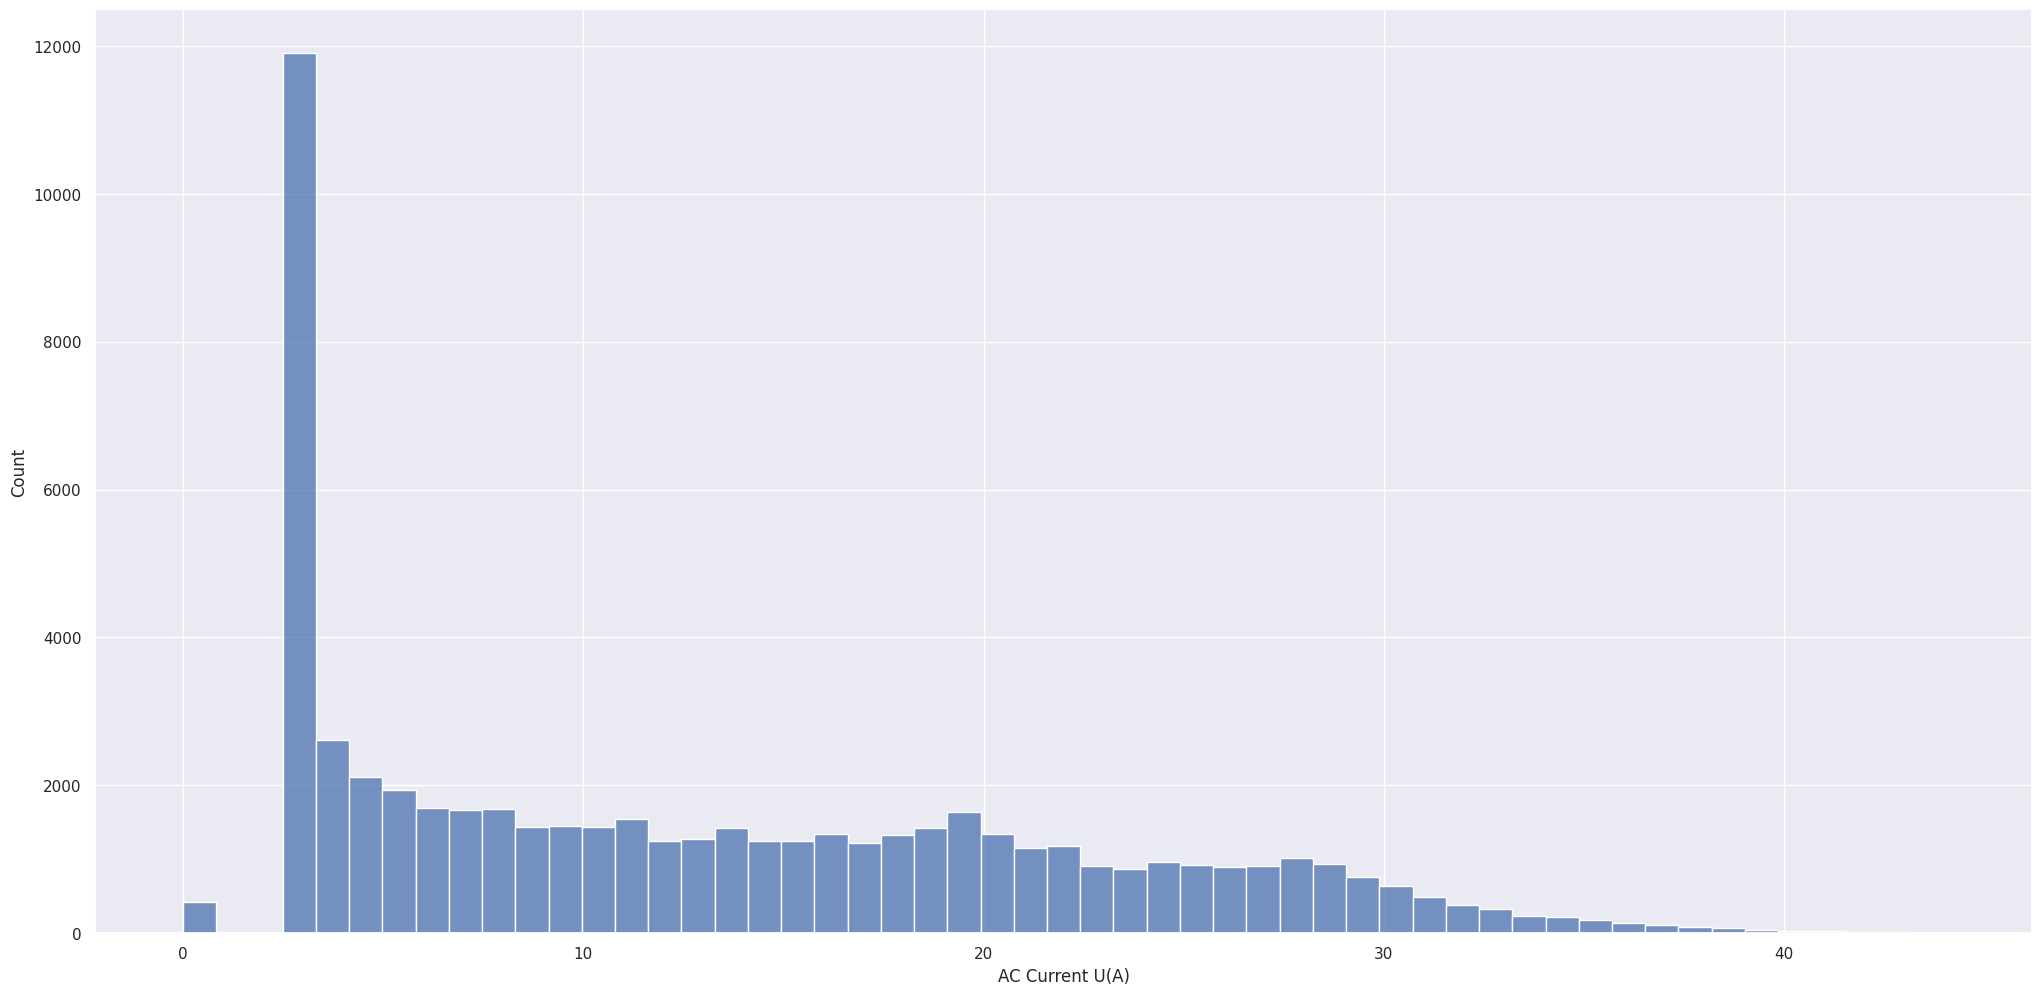

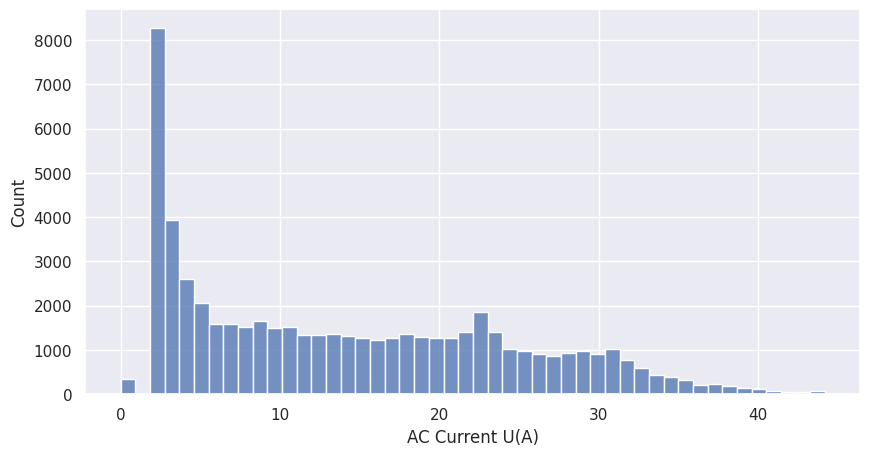

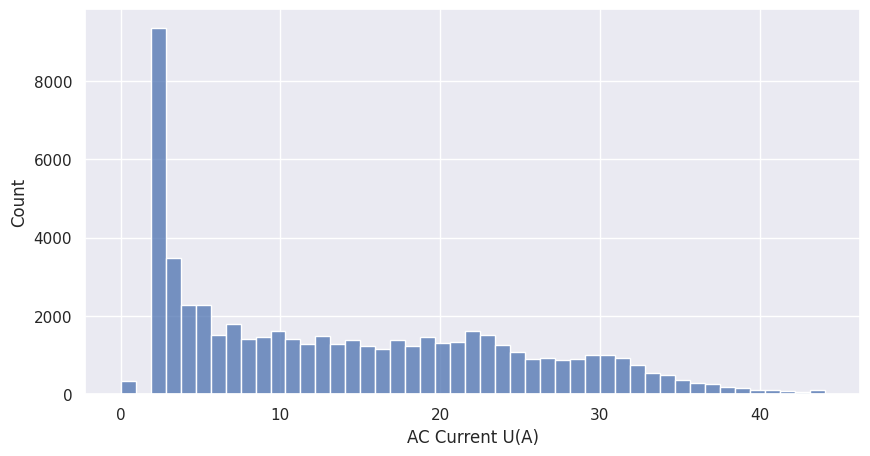

<Figure size 1000x500 with 0 Axes>

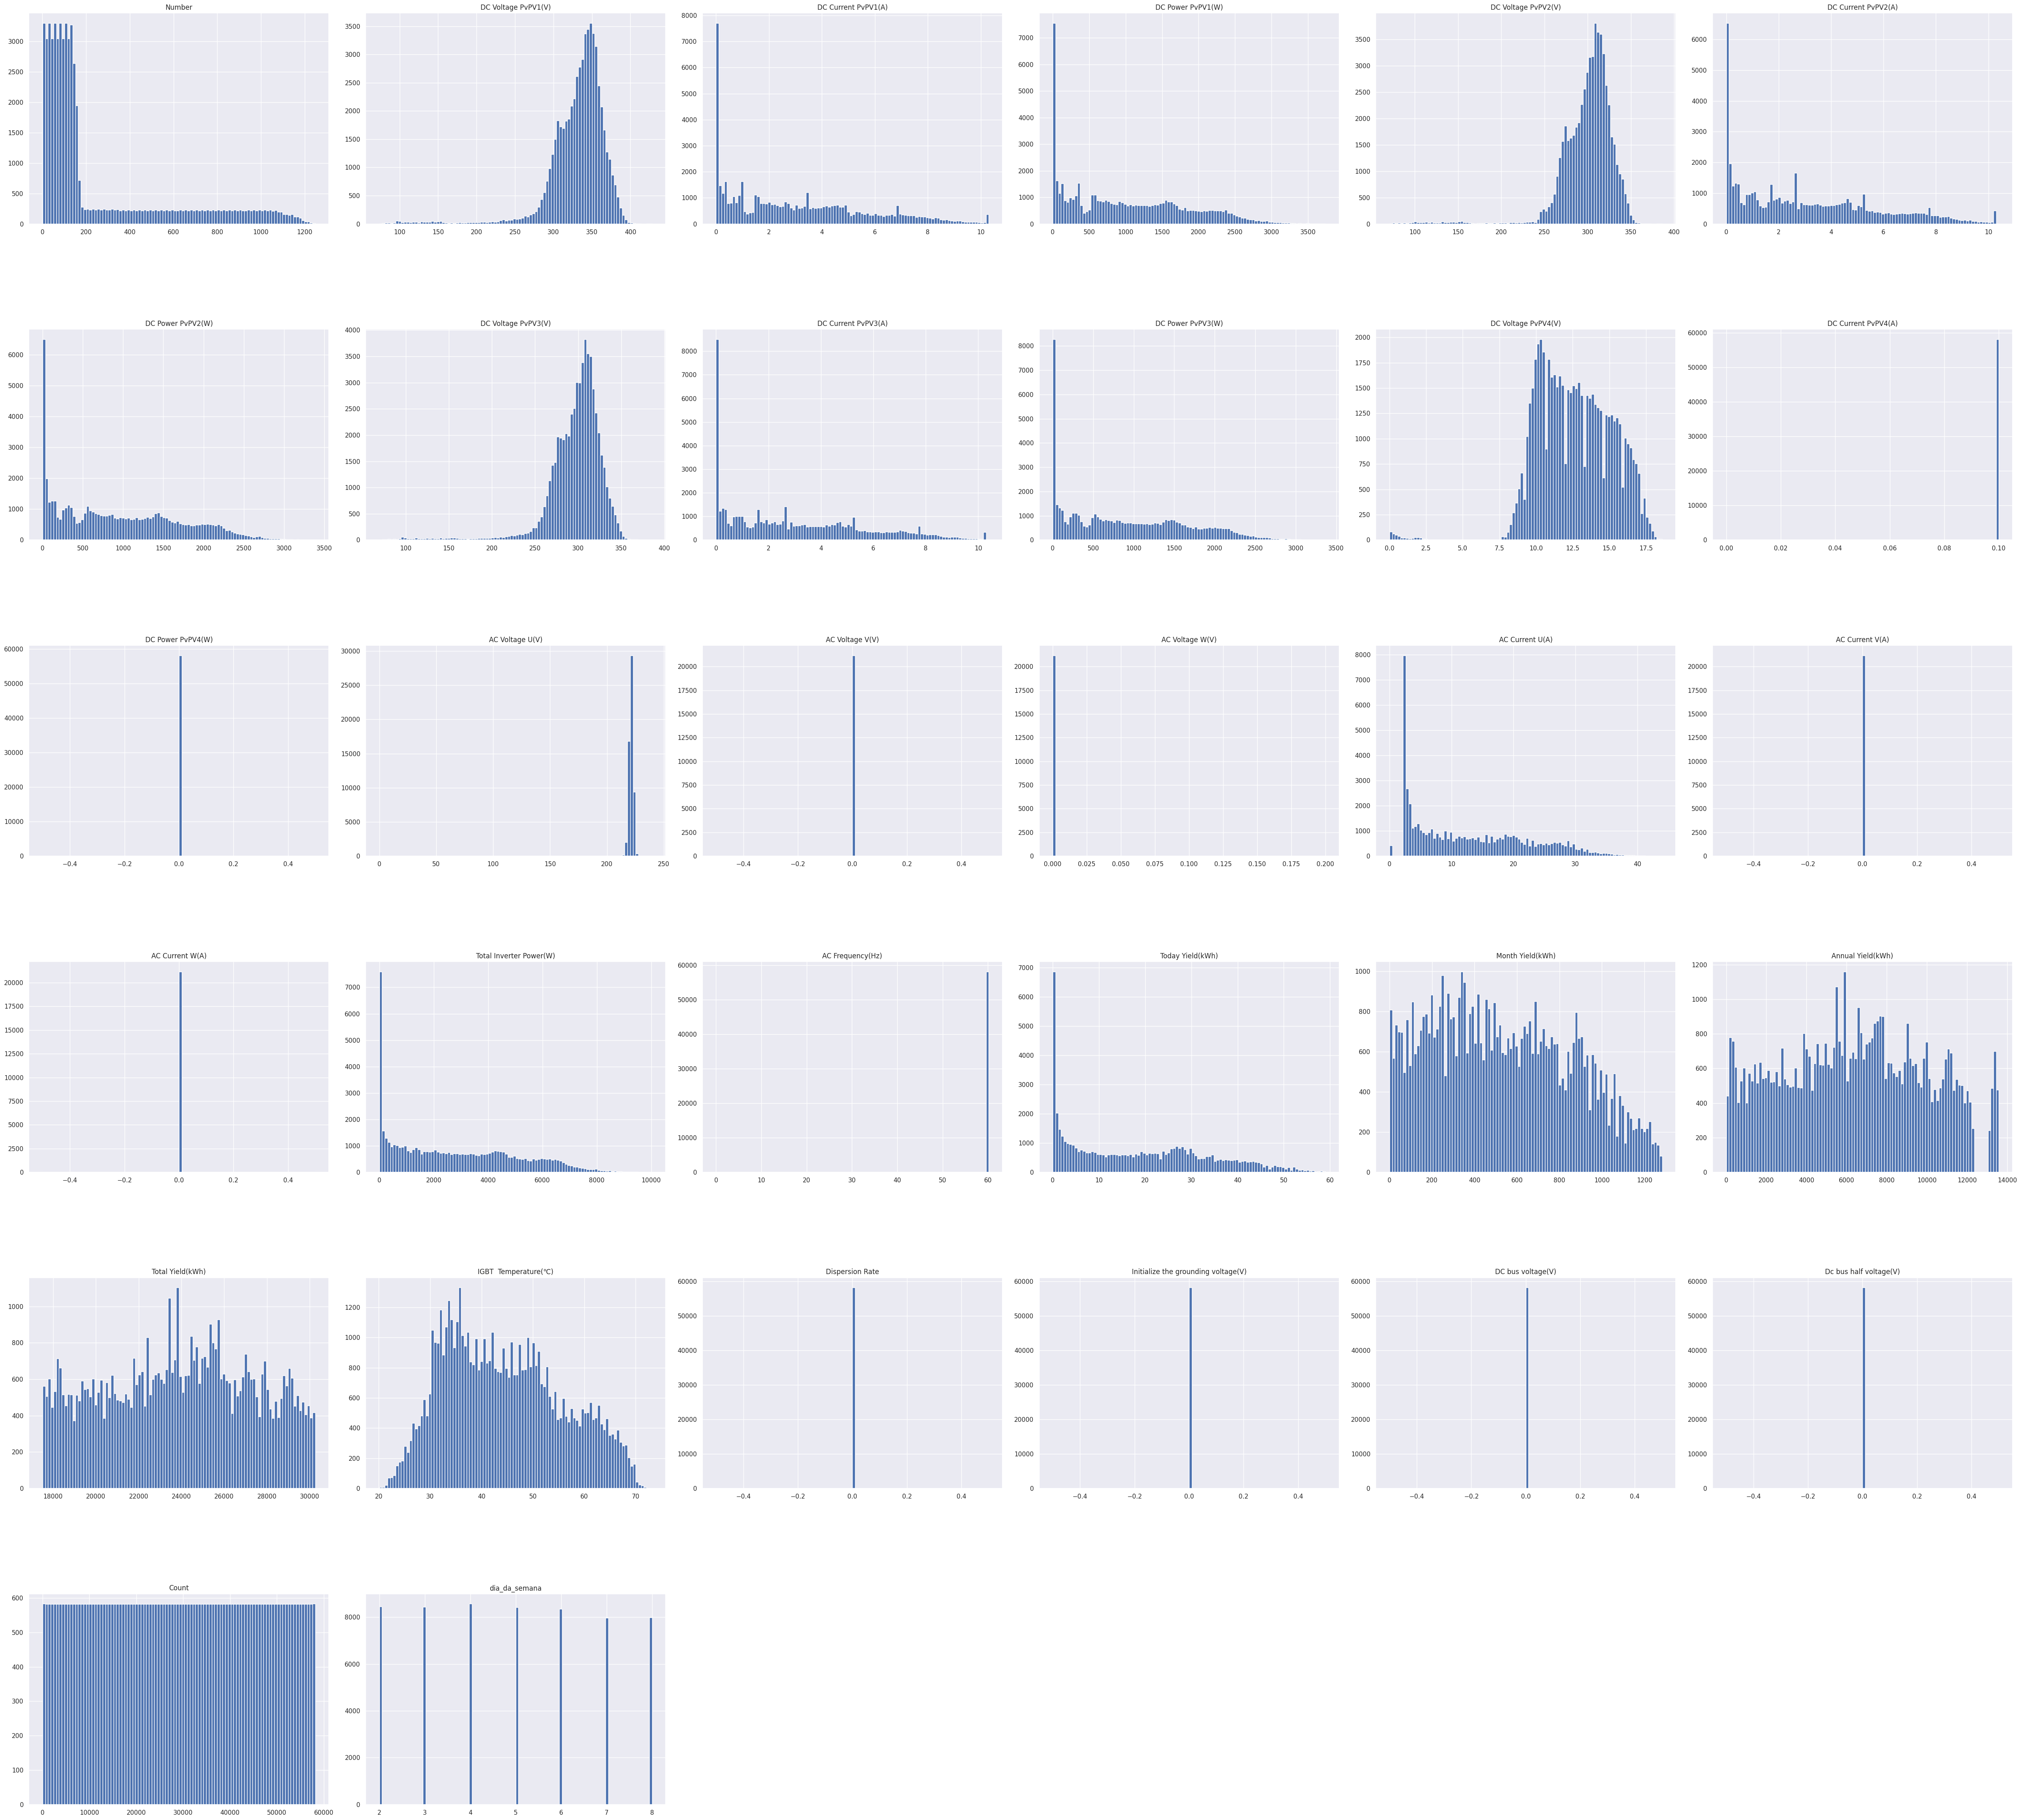

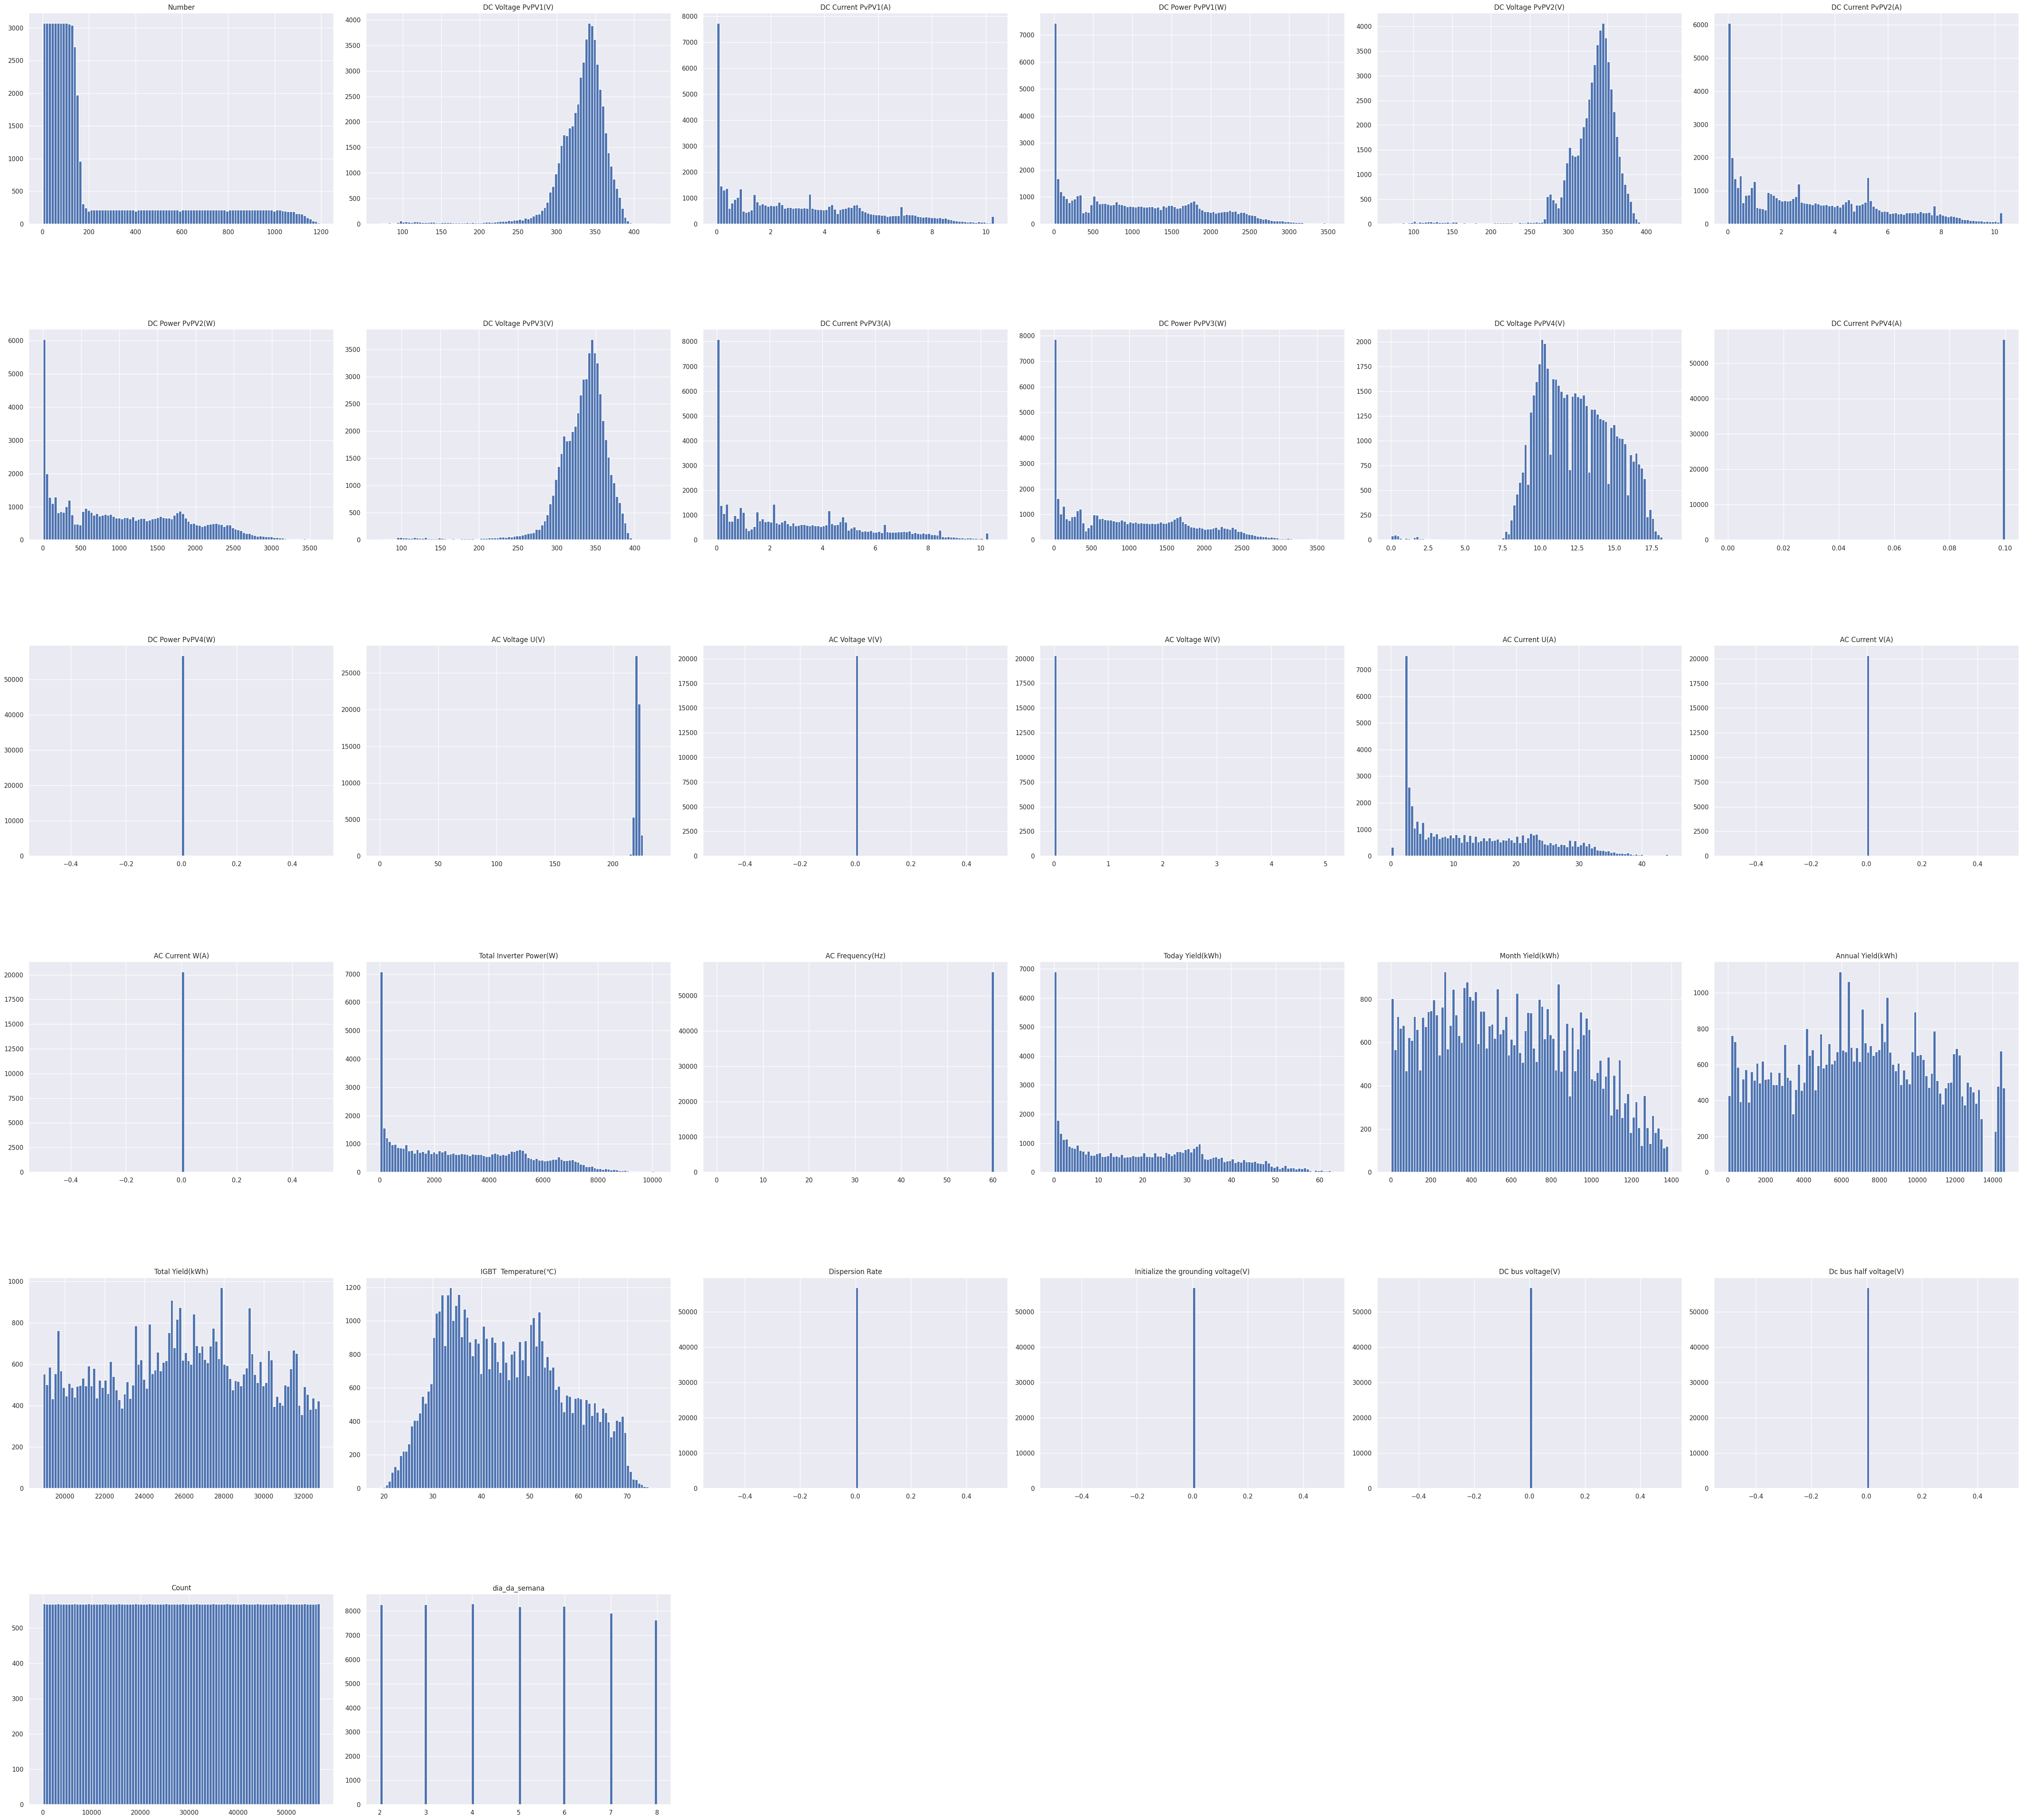

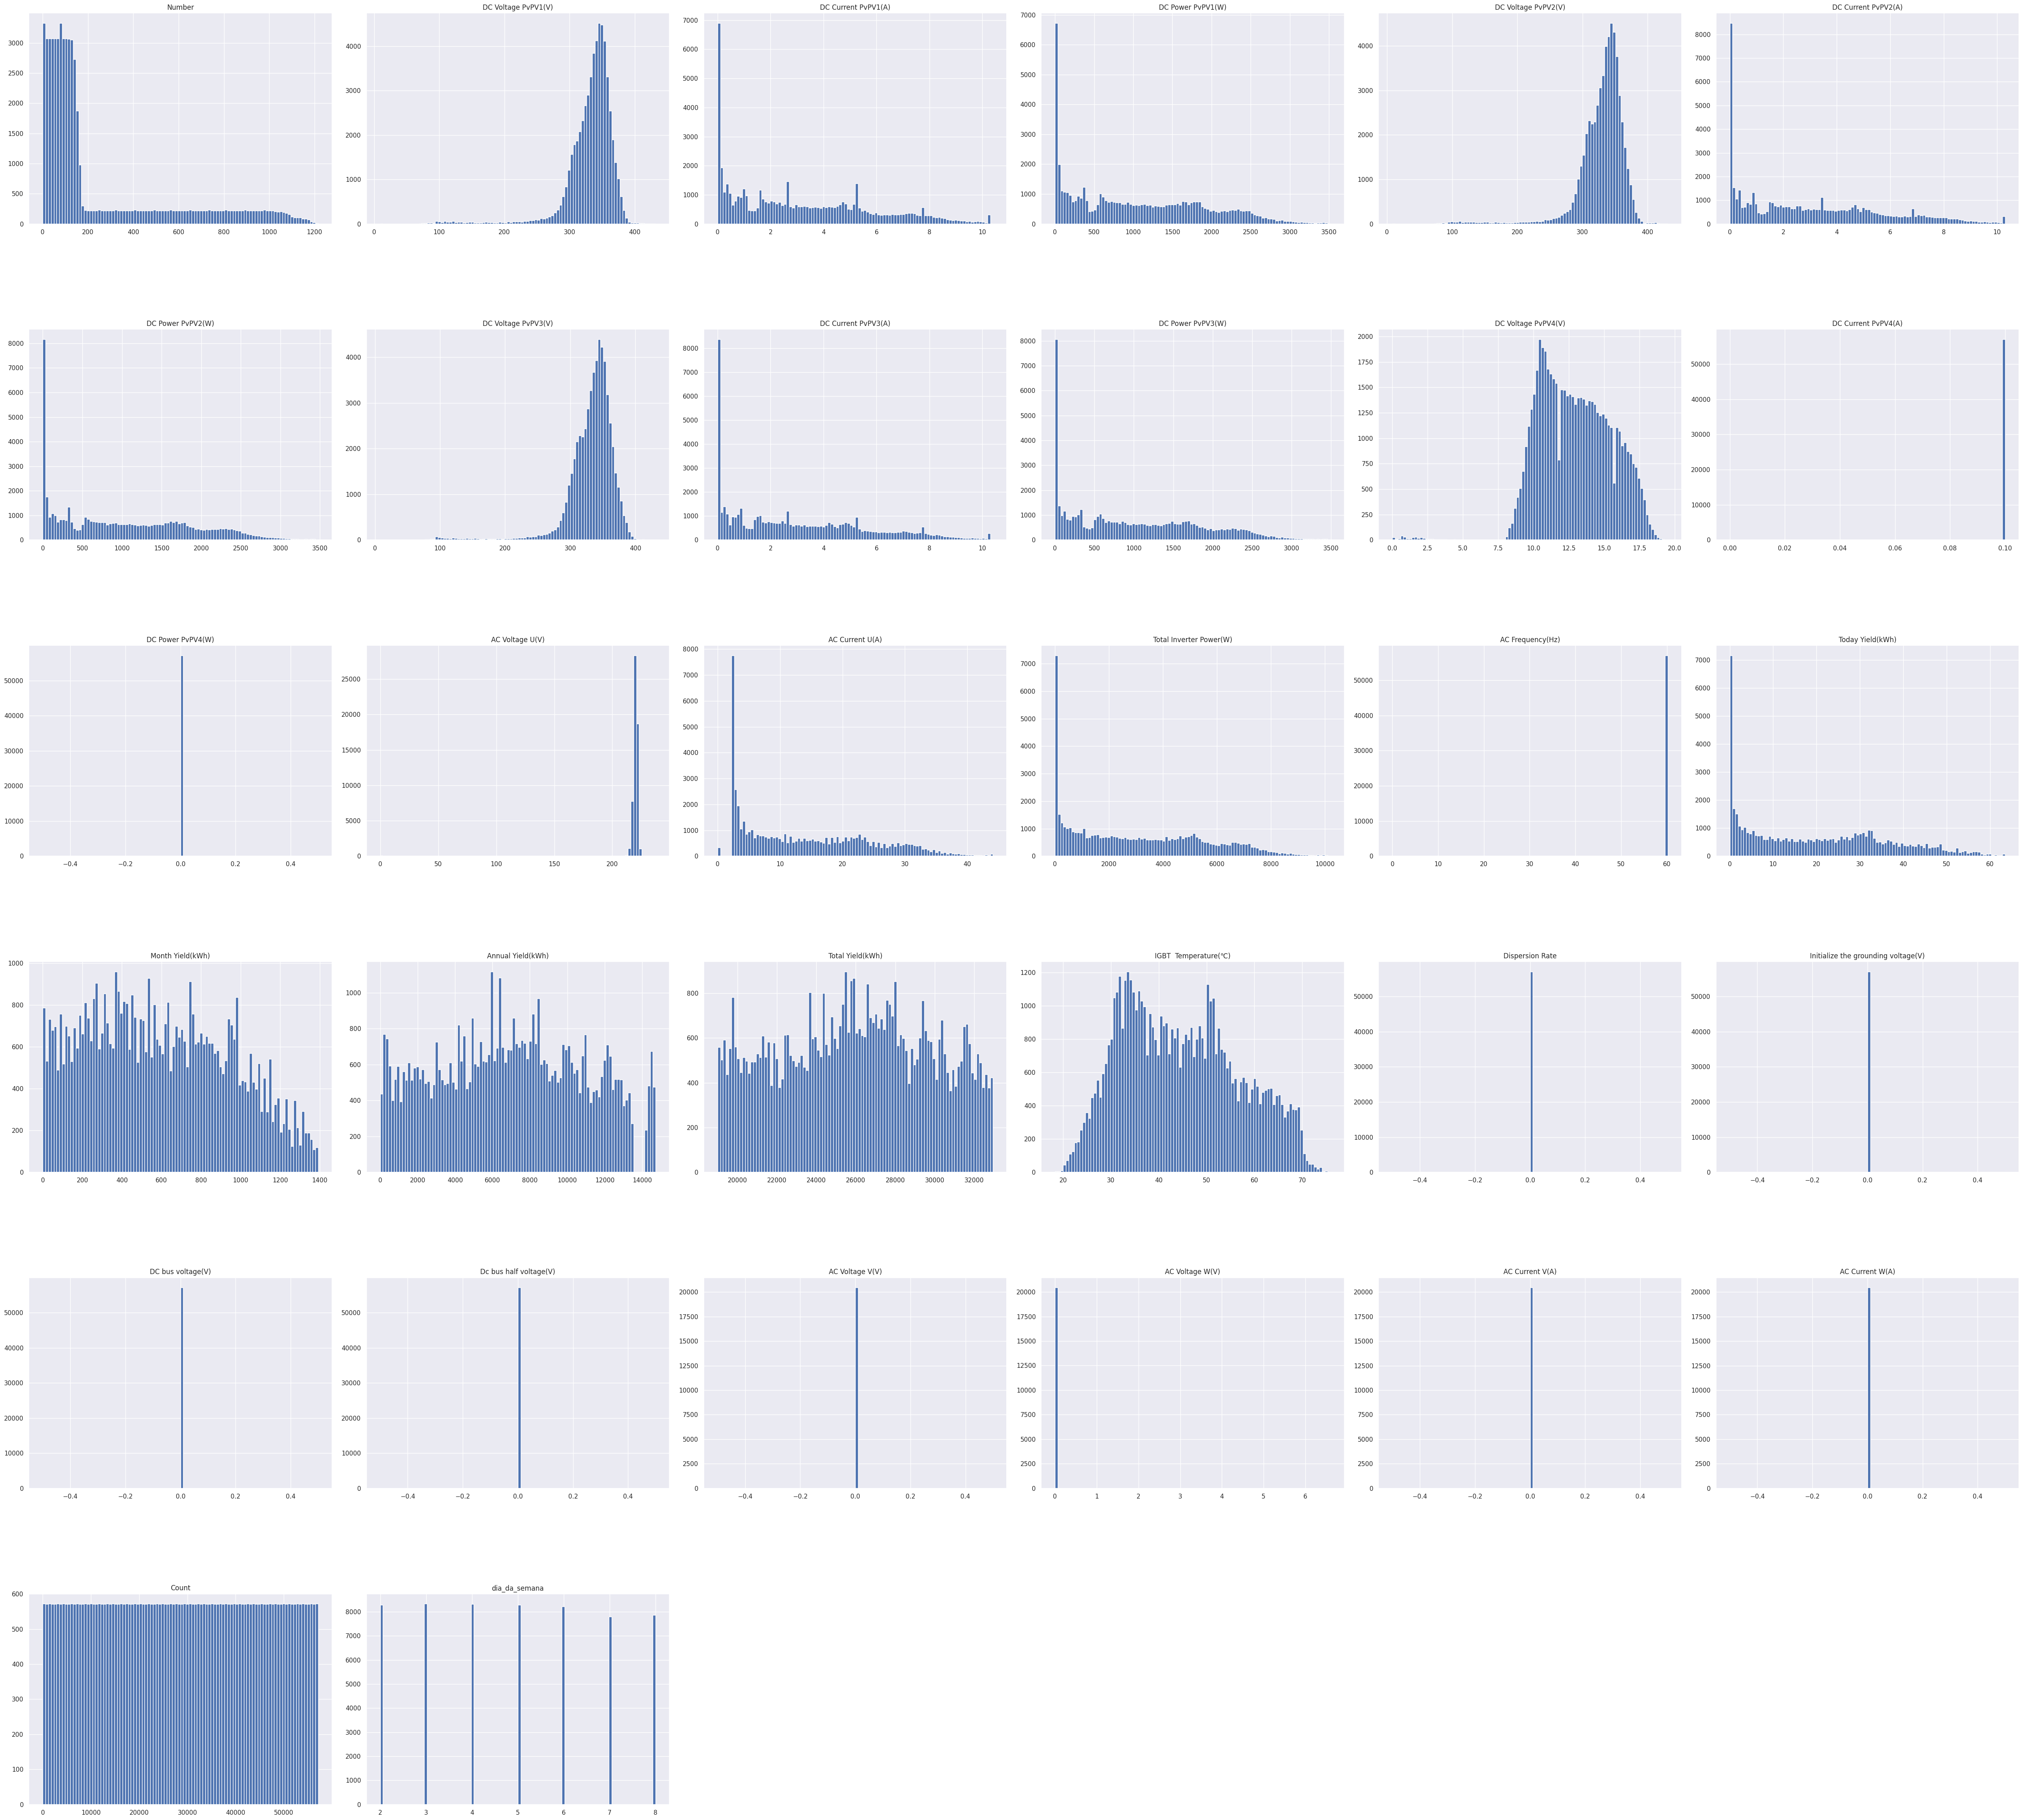

In [31]:
# Supondo que df_41, df_42 e df_44 são objetos DataFrame do pandas

# Plote os histogramas usando seaborn
sns.histplot(df_41_processado['AC Current U(A)'], kde=False)
plt.figure(figsize=(10,5))  # Aumente o espaçamento entre os gráficos

sns.histplot(df_42_processado['AC Current U(A)'], kde=False)
plt.figure(figsize=(10,5))  # Aumente o espaçamento entre os gráficos

sns.histplot(df_44_processado['AC Current U(A)'], kde=False)
plt.figure(figsize=(10,5))  # Aumente o espaçamento entre os gráficos

# Selecione os atributos numéricos e plote os histogramas
num_attributes = df_41.select_dtypes(include = ['int64', 'float64'])
num_attributes.hist(bins=100, figsize=(50,45))  # Aumente o tamanho do gráfico
plt.tight_layout()  # Ajuste o layout para evitar a sobreposição
plt.subplots_adjust(hspace = 0.5)  # Ajuste o espaçamento entre os subplots
plt.show()

num_attributes = df_42.select_dtypes(include = ['int64', 'float64'])
num_attributes.hist(bins=100, figsize=(50,45))  # Aumente o tamanho do gráfico
plt.tight_layout()  # Ajuste o layout para evitar a sobreposição
plt.subplots_adjust(hspace = 0.5)  # Ajuste o espaçamento entre os subplots
plt.show()

num_attributes = df_44.select_dtypes(include = ['int64', 'float64'])
num_attributes.hist(bins=100, figsize=(50,45))  # Aumente o tamanho do gráfico
plt.tight_layout()  # Ajuste o layout para evitar a sobreposição
plt.subplots_adjust(hspace = 0.5)  # Ajuste o espaçamento entre os subplots
plt.show()

## *Seleção de algoritmo*

## *Treinamento de modelo*

## *Validação de modelo*

# **Execução**
* Implementar o modelo de previsão treinado em um ambiente de produção.
* Monitorar regularmente o desempenho do modelo de previsão em um ambiente de produção, fazer ajuste e atualizar conforme a necessecidade.

## *Implementação de modelo*

## *Monitoramento e manuntenção*